In [3]:
import os,sys
from importlib import reload
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterator, *args, **kwargs):
        return iterator

sys.path.append("../tracker")
    
import numpy as np
import scipy as sp
from scipy import constants
from pylab import *

Pretty printing has been turned ON


In [4]:
import KalmanFilter as KF
import kf_debug as debug
import KalmanUtils as KU

reload(KF)
reload(debug)


<module 'kf_debug' from '../tracker\\kf_debug.py'>

In [3]:
# Generated toy hits

N_events=5000

Hit_collection={}
Truth_collection ={}
ParTruth_collection={}

for i in range(N_events):
    Hit_collection[i],Truth_collection[i],ParTruth_collection[i] = \
            debug.gen_hits(x0=0,y0=0,z0=0, t0=0, Ax=0.3,Az=0.2,At=1/30,  N_LAYERS=4)

In [4]:
def run_kf(hits):
    n_hits = len(hits)

    kf = KF.KalmanFilter()

    # Set initial state using first two hits
    m0, V0, H0, Xf0, Cf0, Rf0 = KU.init_state(hits)
    kf.init_filter( m0, V0, H0, Xf0, Cf0, Rf0)
    

    # Feed all measurements to KF
    for i in range(2,n_hits):   
        # some processing
        hit = hits[i]
        dy  = hits[i].y-hits[i-1].y
        mi, Vi, Hi, Fi, Qi = KU.add_measurement(hit, dy)
        
        # pass to KF
        kf.forward_predict(mi, Vi, Hi, Fi, Qi)
        kf.forward_filter()

    # Filter backward
    kf.backward_smooth()
    
    return kf

### Check the result of one event with Kalman/LS

Kalman result [Ax, Az, At]: [22.76459789747605, 15.865563478655531, 2.785752361117517, 0.3080880140387485, 0.199660126763062, 0.02719730171224265]
LS fit result [Ax, Az, At]: [22.76179102 15.87044388  2.78769974  0.30810099  0.19964075  0.02720654]


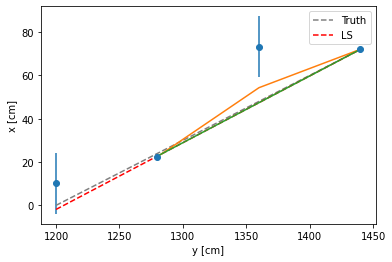

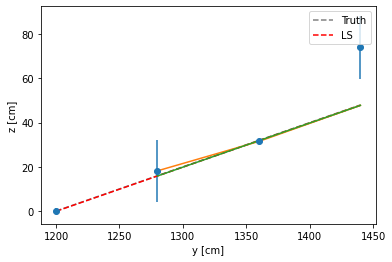

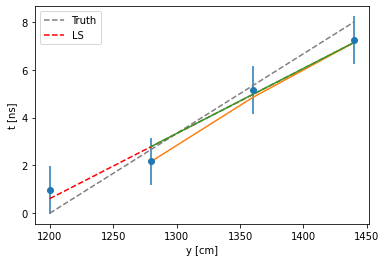

In [6]:
hits = Hit_collection[4]
hits_truth = Truth_collection[0]

# Run Kalman filter
kf = run_kf(hits)
# Run LS fit
guess = debug.guess_track(hits)
fit_ls = debug.fit_track(hits,guess)

print(f"Kalman result [Ax, Az, At]: {fit_ls.values[:]}")
print(f"LS fit result [Ax, Az, At]: {kf.Xsm[0][:]}")

# Digitized hit
hit_x = [hit.x for hit in hits]
hit_y = [hit.y for hit in hits]
hit_z = [hit.z for hit in hits]
hit_t = [hit.t for hit in hits]
hit_x_err = [hit.x_err for hit in hits]
hit_y_err = [hit.y_err for hit in hits]
hit_z_err = [hit.z_err for hit in hits]
hit_t_err = [hit.t_err for hit in hits]

# Truth
hit_truth_x = np.array([hit.x for hit in hits_truth])
hit_truth_y = np.array([hit.y for hit in hits_truth])
hit_truth_z = np.array([hit.z for hit in hits_truth])
hit_truth_t = np.array([hit.t for hit in hits_truth])


# Kalman-Filtred
fit_x = [hit[0] for hit in kf.Xf]
fit_z = [hit[1] for hit in kf.Xf]
fit_t = [hit[2] for hit in kf.Xf]

# Kalman-Smoothed
smooth_x = [hit[0] for hit in kf.Xsm]
smooth_z = [hit[1] for hit in kf.Xsm]
smooth_t = [hit[2] for hit in kf.Xsm]

# LS fit
fit1_res = list(fit_ls.values)
fit_ls_x = fit1_res[0]+fit1_res[3]*(hit_truth_y-hits[1].y)
fit_ls_z = fit1_res[1]+fit1_res[4]*(hit_truth_y-hits[1].y)
fit_ls_t = fit1_res[2]+fit1_res[5]*(hit_truth_y-hits[1].y)




errorbar(hit_y, hit_x, yerr=hit_x_err, fmt="o")
plot(hit_truth_y, hit_truth_x, color="grey", linestyle="--", label="Truth")
plot(hit_truth_y, fit_ls_x,    color="r", linestyle="--", label="LS")
plot(hit_y[1:], fit_x)
plot(hit_y[1:], smooth_x)
xlabel("y [cm]")
ylabel("x [cm]")
legend()
show()

errorbar(hit_y, hit_z, yerr=hit_z_err, fmt="o")
plot(hit_truth_y, hit_truth_z, color="grey", linestyle="--", label="Truth")
plot(hit_truth_y, fit_ls_z,    color="r", linestyle="--", label="LS")
plot(hit_y[1:], fit_z)
plot(hit_y[1:], smooth_z)
xlabel("y [cm]")
ylabel("z [cm]")
legend()
show()

errorbar(hit_y, hit_t, yerr=hit_t_err, fmt="o")
plot(hit_truth_y, hit_truth_t, color="grey", linestyle="--", label="Truth")
plot(hit_truth_y, fit_ls_t,    color="r", linestyle="--", label="LS")
plot(hit_y[1:], fit_t)
plot(hit_y[1:], smooth_t)
xlabel("y [cm]")
ylabel("t [ns]")
legend()
show()

In [7]:
# Performance difference
%timeit -n 10 kf = run_kf(hits)
%timeit -n 10 fit_ls = debug.fit_track(hits,guess)

244 µs ± 57.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.57 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Run more events

In [13]:
results={}
results["hits_truth"]=[]
results["kf_popt"]=[]
results["kf_perr"]=[]
results["kf_chi2"]=[]
results["ls_popt"]=[]
results["ls_perr"]=[]
results["ls_chi2"]=[]

# for i in range(len(Hit_collection)):
for i in range(1000):
    # Get one event
    hits = Hit_collection[i]
    hits_truth = ParTruth_collection[i]
    results["hits_truth"].append(hits_truth)
    dof = 3*len(hits)-6
    
    
    # Run Kalman filter
    kf = run_kf(hits)
    # Run LS fit
    guess = debug.guess_track(hits)
    fit1 = debug.fit_track(hits,guess)
    
    
    results["kf_popt"].append(kf.Xsm[0])
    results["kf_perr"].append(np.sqrt(np.diag(kf.Csm[0])))
    results["kf_chi2"].append(kf.chift_total)
    
    
    lsfit_values = [fit1.values[0],fit1.values[1],fit1.values[2],fit1.values[3],fit1.values[4],fit1.values[5]]
    lsfit_errors = [fit1.errors[0],fit1.errors[1],fit1.errors[2],fit1.errors[3],fit1.errors[4],fit1.errors[5]]
    results["ls_popt"].append(lsfit_values)
    results["ls_perr"].append(lsfit_errors)
    results["ls_chi2"].append(fit1.fval)

for key in results:
    results[key] = np.array(results[key])

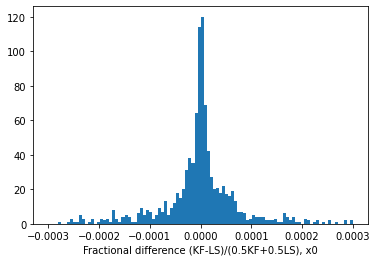

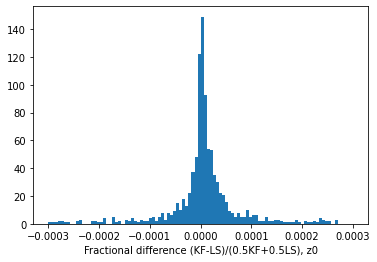

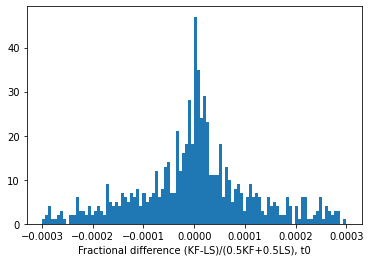

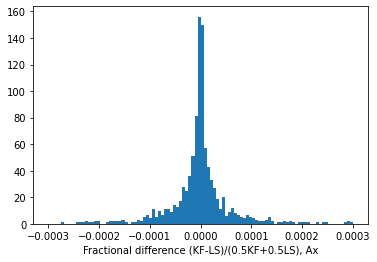

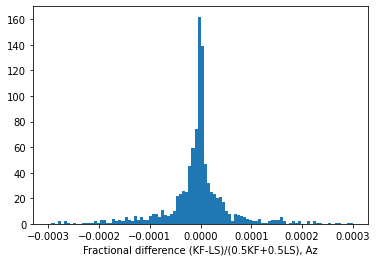

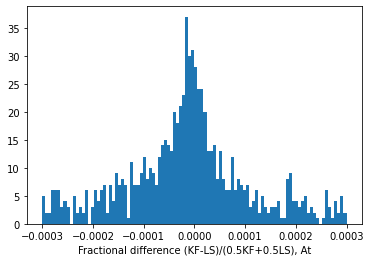

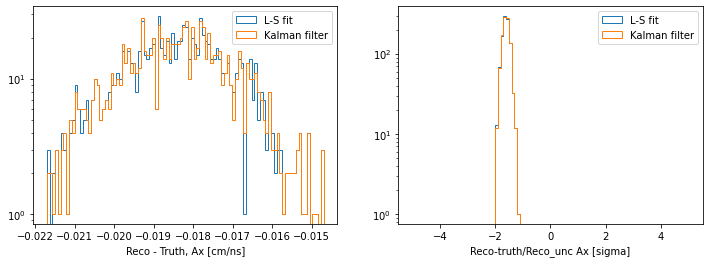

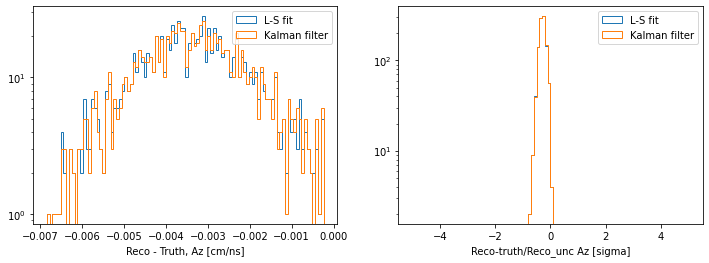

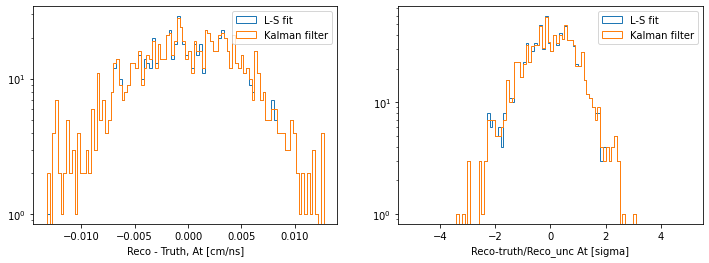

In [14]:
par_names=['x0','z0', 't0',  'Ax', 'Az', 'At'] # Use real world direction
par_unit= ["[cm]","[cm]",'[ns]',"[cm/ns]","[cm/ns]","[cm/ns]"]
# ranges=[(-20,20),(-20,20),(-20,20),(-20,20),(-30,30),(-30,30),(-30,30)]

for ipar in range(6):
    diff=results["kf_popt"][:,ipar] - results["ls_popt"][:,ipar]
    avg =0.5*(results["kf_popt"][:,ipar] + results["ls_popt"][:,ipar])
    hist(diff/avg,bins=100,range=(-0.0003,0.0003))
    xlabel(f"Fractional difference (KF-LS)/(0.5KF+0.5LS), {par_names[ipar]}")
#     title()

    show()

for ipar in range(3,6):
    #_range=ranges[ipar]
    residual_km=results["kf_popt"][:,ipar]-results["hits_truth"][:,ipar]
    residual_ls=results["ls_popt"][:,ipar]-results["hits_truth"][:,ipar]
    _range=(np.percentile(residual_km,1),np.percentile(residual_km,99))
    
    def pull(x_measure, x_truth, x_unc):
        return (x_measure-x_truth)/x_unc
    pull_ls=pull(residual_ls,0,results["ls_perr"][:,ipar])
    pull_km=pull(residual_km,0,results["kf_perr"][:,ipar])
    
    fig,axs=plt.subplots(1,2,figsize=(12,4))
    plt.sca(axs[0])
    plt.hist(residual_ls,histtype="step",bins=100,range=_range,label="L-S fit");#bins=np.linspace(360,500,100));
    plt.hist(residual_km,histtype="step",bins=100,range=_range,label="Kalman filter");#bins=np.linspace(360,500,100));
    plt.legend()
    plt.xlabel(f"Reco - Truth, {par_names[ipar]} {par_unit[ipar]}")
    plt.yscale("log")
    plt.sca(axs[1])
    plt.hist(pull_ls,histtype="step",bins=100,range=(-5,5),label="L-S fit");#bins=np.linspace(360,500,100));
    plt.hist(pull_km,histtype="step",bins=100,range=(-5,5),label="Kalman filter");#bins=np.linspace(360,500,100));
    plt.legend()
    plt.xlabel(f"Reco-truth/Reco_unc {par_names[ipar]} [sigma]")
    plt.yscale("log")    
    
    
    plt.show()

## Run on an event that failed in the tracker

In [13]:
reload(KF)

<module 'KalmanFilter' from 'c:\\Users\\Tom\\OneDrive\\Documents\\JupyterNotebooks\\Physics\\KalmanFilter.py'>

In [14]:
x = [241.62934581783023, 259.25, 221.49664808213277, 227.75]
y = [9894.0, 9975.599999999999, 10057.2, 10138.8]
z = [12456.75, 12450.5, 12461.25, 12450.5]
t = [40.91365706617539, 45.79668867914941, 48.189471653643565, 50.295569678622876]

hits = debug.make_hits(x,y,z,t)

Kalman result [Ax, Az, At]: [258.7337641435588, 12458.91210572832, 44.772055673487245, -0.18957740565542025, 0.026298665329795412, 0.03744300114555704]
LS fit result [Ax, Az, At]: [ 2.58744973e+02  1.24589108e+04  4.47719207e+01 -1.89640181e-01
  2.62589060e-02  3.74246579e-02]
Kalman filter chi2 [0, 8.942541962495875, 2.25655204046314]
Kalman smoother chi2 [9.168409825286703, 3.6790911072627903, 0]


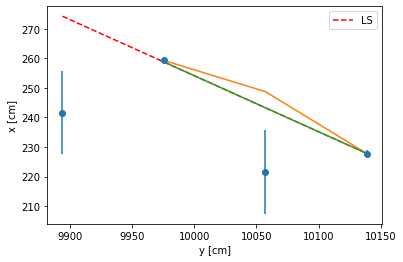

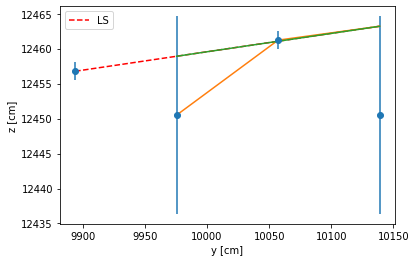

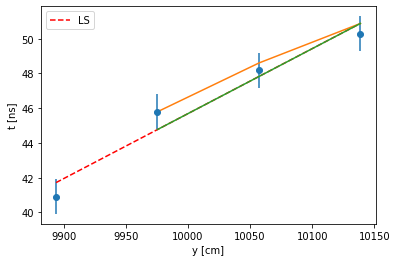

In [15]:
# hits = Hit_collection[4]
# hits_truth = Truth_collection[0]

# Run Kalman filter
kf = run_kf(hits)
# Run LS fit
guess = debug.guess_track(hits)
fit_ls = debug.fit_track(hits,guess)

print(f"Kalman result [Ax, Az, At]: {fit_ls.values[:]}")
print(f"LS fit result [Ax, Az, At]: {kf.Xsm[0][:]}")

print("Kalman filter chi2", kf.chift)
print("Kalman smoother chi2", kf.chism)

# Digitized hit
hit_x = [hit.x for hit in hits]
hit_y = [hit.y for hit in hits]
hit_z = [hit.z for hit in hits]
hit_t = [hit.t for hit in hits]
hit_x_err = [hit.x_err for hit in hits]
hit_y_err = [hit.y_err for hit in hits]
hit_z_err = [hit.z_err for hit in hits]
hit_t_err = [hit.t_err for hit in hits]

# Truth
# hit_truth_x = np.array([hit.x for hit in hits_truth])
hit_truth_y = np.array(hit_y)
# hit_truth_z = np.array([hit.z for hit in hits_truth])
# hit_truth_t = np.array([hit.t for hit in hits_truth])


# Kalman-Filtred
fit_x = [hit[0] for hit in kf.Xf]
fit_z = [hit[1] for hit in kf.Xf]
fit_t = [hit[2] for hit in kf.Xf]

# Kalman-Smoothed
smooth_x = [hit[0] for hit in kf.Xsm]
smooth_z = [hit[1] for hit in kf.Xsm]
smooth_t = [hit[2] for hit in kf.Xsm]

# LS fit
fit1_res = list(fit_ls.values)
fit_ls_x = fit1_res[0]+fit1_res[3]*(hit_truth_y-hits[1].y)
fit_ls_z = fit1_res[1]+fit1_res[4]*(hit_truth_y-hits[1].y)
fit_ls_t = fit1_res[2]+fit1_res[5]*(hit_truth_y-hits[1].y)




errorbar(hit_y, hit_x, yerr=hit_x_err, fmt="o")
plot(hit_truth_y, fit_ls_x,    color="r", linestyle="--", label="LS")
plot(hit_y[1:], fit_x)
plot(hit_y[1:], smooth_x)
xlabel("y [cm]")
ylabel("x [cm]")
legend()
show()

errorbar(hit_y, hit_z, yerr=hit_z_err, fmt="o")
plot(hit_truth_y, fit_ls_z,    color="r", linestyle="--", label="LS")
plot(hit_y[1:], fit_z)
plot(hit_y[1:], smooth_z)
xlabel("y [cm]")
ylabel("z [cm]")
legend()
show()

errorbar(hit_y, hit_t, yerr=hit_t_err, fmt="o")
plot(hit_truth_y, fit_ls_t,    color="r", linestyle="--", label="LS")
plot(hit_y[1:], fit_t)
plot(hit_y[1:], smooth_t)
xlabel("y [cm]")
ylabel("t [ns]")
legend()
show()